In [1]:
import sys
sys.path.append('..')

In [29]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from sklearn.decomposition import PCA

In [3]:
from DomainPrediction.protein.base import BaseProtein
from DomainPrediction.protein.base import FoldedProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools
from DomainPrediction.utils.tmalign import TMalign
from DomainPrediction.utils.constants import *
from DomainPrediction.esm.esm2 import ESM2

In [4]:
root = '../..'
data_path = os.path.join(root, 'Data/round_2_exp')
gxps_path = os.path.join(root, 'Data/gxps')

#### Load ESM2

In [25]:
esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt')

#### Round 1 setup

First we need to merge the A and C domains of round 1 extractions and create a fasta file \
For metadata - compute perplexity, add titer values and seq ID to wild type \
Create basis plots for perplexity and seq id

In [11]:
gxps_wt_seq = helper.read_fasta(os.path.join(gxps_path, 'GxpS_ATC.fasta'), mode='str')[0]
gxps_wt_protein = BaseProtein(sequence=gxps_wt_seq, id='gxps_wt')

In [15]:
# ## Merging A and C domains to extraction of round 1 fasta
# records = helper.read_fasta(os.path.join(data_path, 'round_1_extraction.fasta'))
# for rec in records:
#     helper.create_fasta(sequences={
#         rec.id: gxps_wt_protein.get_residues(A_gxps_atc) + str(rec.seq) + gxps_wt_protein.get_residues(C_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'round_1.fasta'),
#     append=True)

In [21]:
# ## Creating a fasta file of T domains
# records = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
# for rec in records:
#     protein = BaseProtein(sequence=str(rec.seq), id=rec.id)
#     helper.create_fasta(sequences={
#         rec.id: protein.get_residues(T_gxps_atc)
#     }, 
#     file=os.path.join(data_path, 'round_1.T.fasta'),
#     append=True)

In [24]:
# ## Seq ID to WT xgps and save to metadata
# seq_ids = metrics.compute_sequence_identity(
#     wt = os.path.join(gxps_path, 'GxpS.T.fasta'),
#     gen = os.path.join(data_path, 'round_1.T.fasta'),
#     hmm = os.path.join(root, 'src/DomainPrediction/hmm/PF00550_T.hmm')
# )
# records = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
# meta_file = os.path.join(os.path.join(data_path, 'round_1_metadata.json'))
# for rec, seq_id in zip(records, seq_ids):
#     helper.update_metadata_json(meta_file, rec.id, 'seq_id_WT(T)', seq_id, force=False)

Perplexity calculation in the cluster : use the following code block

```python
meta_file = os.path.join(os.path.join(data_path, 'round_1_metadata.json'))
records = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
for rec in records:
    perplexity = metrics.compute_perplexity(esm2, str(rec.seq))

    print(rec.id, perplexity)
    helper.update_metadata_json(meta_file, rec.id, 'esm2_650M_perplexity', perplexity, force=False)
```

In [28]:
# ## Adding titer values to metadata
# titers = [0.041674705, 0.032554255, 0.062307446, 0.003060206, 0.020001747, 0, 0, 0.015385128, 0, 0, 0.003624185, 0]
# records = helper.read_fasta(os.path.join(data_path, 'round_1.fasta'))
# meta_file = os.path.join(os.path.join(data_path, 'round_1_metadata.json'))
# for rec, seq_id in zip(records, titers):
#     helper.update_metadata_json(meta_file, rec.id, 'titer', seq_id, force=False)

#### Round 1 Analysis

In [37]:
meta_file = os.path.join(os.path.join(data_path, 'round_1_metadata.json'))
with open(meta_file) as f:
    round_1_meta = json.load(f)
df_meta = pd.DataFrame(round_1_meta).T

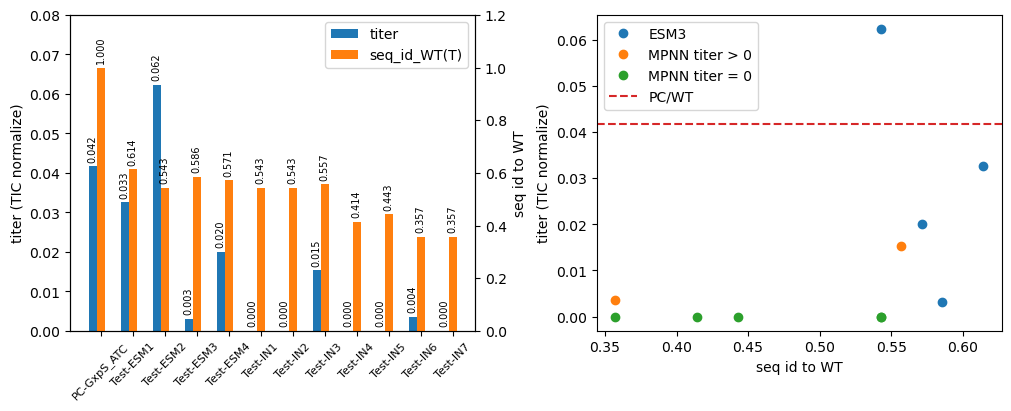

In [105]:
width = 0.25  # the width of the bars
multiplier = 0
x = np.arange(df_meta.shape[0])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), layout='constrained')
for col in ['titer', 'seq_id_WT(T)']:
    offset = width*multiplier
    if col == 'titer':
        rects = ax[0].bar(x + offset, df_meta[col], width, label=col)
        ax[0].bar_label(rects, padding=3, size=7, fmt=f'%.3f', rotation='vertical', annotation_clip=True)
    else:
        ax2 = ax[0].twinx()
        rects = ax[0].bar(x + offset, 0, width, label=col) ## trck tro bring labels
        rects = ax2.bar(x + offset, df_meta[col], width, label=col, color='tab:orange')
        ax2.bar_label(rects, padding=3, size=7, fmt=f'%.3f', rotation='vertical', annotation_clip=True)

    multiplier += 1
ax[0].set_ylim((0, 0.08))    
ax2.set_ylim((0, 1.2))
ax[0].set_ylabel('titer (TIC normalize)')
ax2.set_ylabel('seq id to WT')
ax[0].set_xticks(x + width, df_meta.index, size=8, rotation=45)
ax[0].legend()

ax[1].plot(df_meta.loc[['ESM' in i for i in df_meta['titer'].index], 'seq_id_WT(T)'], df_meta.loc[['ESM' in i for i in df_meta['titer'].index], 'titer'], 'o', label='ESM3')
mpnn_mask = np.array(['IN' in i for i in df_meta['titer'].index])
ax[1].plot(df_meta.loc[mpnn_mask & (df_meta['titer'] > 0), 'seq_id_WT(T)'], df_meta.loc[mpnn_mask & (df_meta['titer'] > 0), 'titer'], 'o', label='MPNN titer > 0')
ax[1].plot(df_meta.loc[mpnn_mask & ~(df_meta['titer'] > 0), 'seq_id_WT(T)'], df_meta.loc[mpnn_mask & ~(df_meta['titer'] > 0), 'titer'], 'o', label='MPNN titer = 0')
ax[1].axhline(y=df_meta.loc['PC-GxpS_ATC', 'titer'], ls='--', label='PC/WT', color='tab:red')
ax[1].set_ylabel('titer (TIC normalize)')
ax[1].set_xlabel('seq id to WT')
ax[1].legend()

plt.show()

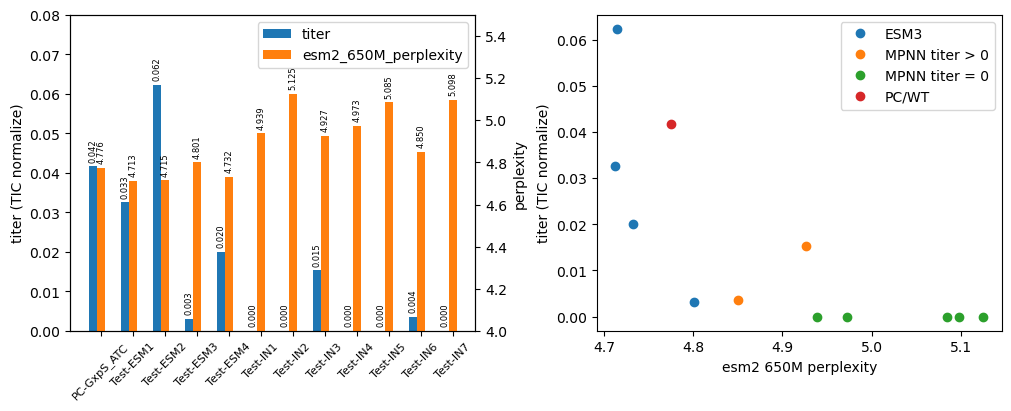

In [113]:
width = 0.25  # the width of the bars
multiplier = 0
x = np.arange(df_meta.shape[0])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), layout='constrained')
for col in ['titer', 'esm2_650M_perplexity']:
    offset = width*multiplier
    if col == 'titer':
        rects = ax[0].bar(x + offset, df_meta[col], width, label=col)
        ax[0].bar_label(rects, padding=3, size=6, fmt=f'%.3f', rotation='vertical', annotation_clip=True)
    else:
        ax2 = ax[0].twinx()
        rects = ax[0].bar(x + offset, 0, width, label=col) ## trck tro bring labels
        rects = ax2.bar(x + offset, df_meta[col], width, label=col, color='tab:orange')
        ax2.bar_label(rects, padding=3, size=6, fmt=f'%.3f', rotation='vertical', annotation_clip=True)

    multiplier += 1
ax[0].set_ylim((0, 0.08))    
ax2.set_ylim((4, 5.5))
ax[0].set_ylabel('titer (TIC normalize)')
ax2.set_ylabel('perplexity')
ax[0].set_xticks(x + width, df_meta.index, size=8, rotation=45)
ax[0].legend()

ax[1].plot(df_meta.loc[['ESM' in i for i in df_meta['titer'].index], 'esm2_650M_perplexity'], df_meta.loc[['ESM' in i for i in df_meta['titer'].index], 'titer'], 'o', label='ESM3')
mpnn_mask = np.array(['IN' in i for i in df_meta['titer'].index])
ax[1].plot(df_meta.loc[mpnn_mask & (df_meta['titer'] > 0), 'esm2_650M_perplexity'], df_meta.loc[mpnn_mask & (df_meta['titer'] > 0), 'titer'], 'o', label='MPNN titer > 0')
ax[1].plot(df_meta.loc[mpnn_mask & ~(df_meta['titer'] > 0), 'esm2_650M_perplexity'], df_meta.loc[mpnn_mask & ~(df_meta['titer'] > 0), 'titer'], 'o', label='MPNN titer = 0')
ax[1].plot(df_meta.loc['PC-GxpS_ATC', 'esm2_650M_perplexity'], df_meta.loc['PC-GxpS_ATC', 'titer'], 'o', label='PC/WT', color='tab:red')
ax[1].set_ylabel('titer (TIC normalize)')
ax[1].set_xlabel('esm2 650M perplexity')
ax[1].legend()

plt.show()

#### 

In [8]:
gxps_wt_seq = helper.read_fasta(os.path.join(root, 'Data/gxps/GxpS_ATC.fasta'), mode='str')[0]
gxps_wt_protein = BaseProtein(sequence=gxps_wt_seq, id='gxps_wt')

In [9]:
file = os.path.join(data_path, 'esm3_400.fasta')
esm3_sequences = helper.read_fasta(file)
file = os.path.join(data_path, 'evodiff_400.fasta')
evodiff_sequences = helper.read_fasta(file)

In [10]:
len(esm3_sequences), len(evodiff_sequences), len(esm3_sequences[0].seq), len(evodiff_sequences[0].seq)

(400, 400, 1034, 1034)

In [ ]:
def get_embeddings(sequences):
    embeddings = []
    for rec in tqdm(sequences):
        seq = ''.join([rec.seq[i] for i in range(len(rec.seq)) if i not in A_gxps_atc + C_gxps_atc])
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

def get_embeddings(sequences):
    embeddings = []
    for rec in tqdm(sequences):
        seq = ''.join([rec.seq[i] for i in range(len(rec.seq)) if i not in A_gxps_atc + C_gxps_atc])
        rep = esm2.get_res(sequence=seq)
        embeddings.append(rep['representations'][33].mean(1).numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings

In [ ]:
esm3_embeddings = get_embeddings(esm3_sequences)
evodiff_embeddings = get_embeddings(evodiff_sequences)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=0, max_iter=1000)
esm3_clusters = kmeans.fit_predict(esm3_embeddings)
evodiff_clusters = kmeans.fit_predict(evodiff_embeddings)

In [ ]:
pca = PCA(n_components=2)

fig, ax = plt.subplots(1,2, figsize=(6,3), layout="constrained")
reduced_embeddings = pca.fit_transform(esm3_embeddings)
ax[0].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=esm3_clusters)
reduced_embeddings = pca.fit_transform(evodiff_embeddings)
ax[1].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=evodiff_clusters)
# ax[1].set_xlim(right=0.5)
plt.show()